# Fine-tuning ViT on Cifar2


Note that `Cifar2` denotes the `Interview dataset`.


## Introduction

The task requires training a binary classifier on the provided data set by adapting the Vision Transformer(ViT). The dataset
includes two classes (ants and bees). For each class, there are about 120 images for training and about 80 images for
validation. 

The details of the dataset are as follows.

|       |Train  | Val  | sum  |
|-------|:-----:|:----:|:----:|
|**ant**|124    |70    |194   |
|**bee**|121    |83    |204   |
|**sum**|245    |153   |398   |

Considering this dataset is quite small, there is no reason to train the model from scratch. The pre-trained Vit model on the large dataset was used as a feature extractor, and then fine-tune the model for the provided dataset.

For two different pre-trained Vit models (ViT-Base and ViT-Large), two transfer learning scenarios are considered respectively in this work:
- Finetuning the entire new model
- Finetuning the newly constructed layer only

|                   |Pre-trained Model | Finetuning the entire new model|
|-------------------|:------------------:|:------------------:|
|ViT-B_16 Last layer|ViT-B/16          |No                |
|ViT-B_16 ALL layers|ViT-B/16          |Yes               |
|ViT-L_16 ALL layers|ViT-L/16          |No                |
|ViT-L_16 Last layer|ViT-L/16          |Yes               |

- ViT-B/16 means the "Base" variant ViT with 16x16 input batch size.
- ViT-L/16 means the "Large" variant ViT with 16x16 input batch size.


## Coding

### Create dataset and dataloader for Cifar2

In [ ]:
"""
-*-coding = utf-8 -*-
__author: topsy
@time:2021/12/12 23:12
/utils/cifa2_data_loader.py
"""

from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler
from torchvision import transforms, datasets
import os

img_size = 224




def get_cifar2_dataset(args = None):
    print("***** Current use the cifar2 dataset for train and test.  *****")
    cifar2_dir = './data/hymenoptera_data'
    if args:
        img_size = args.img_size
    else:
        img_size = 224
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    trainset = datasets.ImageFolder(root=os.path.join(cifar2_dir, "train"),
                                    transform=transform_train)
    testset = datasets.ImageFolder(root=os.path.join(cifar2_dir, "val"),
                                   transform=transform_test)
    return trainset, testset


def get_cifar2_dataloader(args = None):
    if args:
        train_batch_size = args.train_batch_size
        eval_batch_size = args.eval_batch_size
    else:
        train_batch_size = 32
        eval_batch_size = 32
    trainset, testset = get_cifar2_dataset()
    train_sampler = RandomSampler(trainset)
    test_sampler = SequentialSampler(testset)
    train_loader = DataLoader(trainset,
                              sampler=train_sampler,
                              batch_size=train_batch_size,
                              num_workers=4,
                              pin_memory=True)
    test_loader = DataLoader(testset,
                             sampler=test_sampler,
                             batch_size=eval_batch_size,
                             num_workers=4,
                             pin_memory=True) if testset is not None else None

    return train_loader, test_loader




### Create the same model as ViT except for the last layer

In [ ]:
def setup(args):
    # Prepare model
    config = CONFIGS[args.model_type]

    # num_classes = 10 if args.dataset == "cifar10" else 100
    if args.dataset == "cifar10":
        num_classes = 10
    elif args.dataset == "cifar2":
        num_classes = 2
    else:
        num_classes = 100

    model = VisionTransformer(config, args.img_size, zero_head=True, num_classes=num_classes)
    model.load_from(np.load(args.pretrained_dir))

    # load the pretrained model and freeze the all network except the last layer
    if args.dataset == "cifar2":
        print("*****  Change the last layer of network and initials with 0.0 *****")
        # change the last layer
        model.head = Linear(config.hidden_size, num_classes)
        # intial head with zeros
        model.head.weight.data.fill_(0.0)
        model.head.bias.data.fill_(0.0)

### Train Pipeline

- Load the pretrained model
- Fine-tuning the all layers with different learning rate
- Fine-tuning the newly constructed layer only



In [ ]:
def train_cifar2(args, model):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=os.path.join("logs", args.name))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    # Prepare dataset
    trainset, testset = get_cifar2_dataset()
    dataset_sizes = {"train": len(trainset), "test": len(testset)}
    train_loader, test_loader = get_cifar2_dataloader(args)

    # For Cifar2
    if args.dataset == "cifar2":
        # get all parameters of the network except the last layer
        vit_code_param_lst = []
        head_param_lst = []
        for name, param in model.named_parameters():
            if name == "head.weight" or name == "head.bias":
                head_param_lst.append(param)
            else:
                vit_code_param_lst.append(param)
        if args.freeze == -1:
            # only optimize the parameters of the last layer
            print("***** Only optimize the parameters of the last layer")
            for param in vit_code_param_lst:
                param.requires_grad = False
            optimizer = torch.optim.SGD(model.head.parameters(),
                                        lr=args.learning_rate * 10,
                                        momentum=0.9,
                                        weight_decay=args.weight_decay)
        else:
            # Optimize all parameters but with different learning rate
            print("*****  Optimize all parameters but with different learning rate")
            optimizer = torch.optim.SGD([
                {"params": vit_code_param_lst},
                {"params": head_param_lst, "lr": args.learning_rate}
            ],
                lr=args.learning_rate,
                momentum=0.9,
                weight_decay=args.weight_decay)
    t_total = args.num_steps
    if args.dataset == "cifar2":
        scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Total optimization steps = %d", args.num_steps)
    logger.info("  Instantaneous batch size per GPU = %d", args.train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)

    model.zero_grad()
    set_seed(args)  # Added here for reproducibility (even between python 2 and 3)
    losses = AverageMeter()
    global_step, best_acc = 0, 0
    while True:
        loss_fct = CrossEntropyLoss()
        for epoch in range(args.num_steps):
            if (epoch + 1) % args.eval_every == 0:
                logger.info("Epoch {} / {}".format(epoch + 1, args.num_steps))
            global_step += 1
            model.train()
            epoch_loss = 0.0
            epoch_corrects = 0
            for x, y in train_loader:
                x = x.to(args.device)
                y = y.to(args.device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(True):
                    logits, _ = model(x)
                    _, preds = torch.max(logits, dim=-1)
                    loss = loss_fct(logits.view(-1, args.num_classes), y.view(-1))
                    # compute grad and update parameters
                    loss.backward()
                    optimizer.step()
                epoch_loss += loss.item() * x.size(0)
                epoch_corrects += torch.sum(preds == y.data)

            epoch_loss = epoch_loss * 1.0 / dataset_sizes["train"]
            epoch_acc = epoch_corrects * 1.0 / dataset_sizes["train"]
            logger.info('Train Loss: {:.4f} Acc: {:.4f} LR: {}'.format(epoch_loss, epoch_acc, scheduler.get_lr()[0]))

            # if global_step % args.eval_every == 0 :
            accuracy = valid(args, model, writer, test_loader, global_step)
            if best_acc < accuracy:
                save_model(args, model)
                best_acc = accuracy

            scheduler.step()
            writer.add_scalar("train/loss", scalar_value=epoch_loss, global_step=global_step)
            writer.add_scalar("train/lr", scalar_value=scheduler.get_lr()[0], global_step=global_step)
            writer.add_scalar("train/acc", scalar_value=epoch_acc, global_step=global_step)

        if global_step % t_total == 0:
            break

    if args.local_rank in [-1, 0]:
        writer.close()
    logger.info("Best Accuracy: \t%f" % best_acc)
    logger.info("End Training!")


## Results

### Traing and testing accuracy and loss

|          |ViT-B_16 Last layer| ViT-B_16 ALL layers|ViT-L_16 Last layers|ViT-L_16 ALL layer|
|----------|:----------------:|:------------------:|:----------------:|:-----------------:|
|Train Acc |**99.99**         |99.59               |**99.99**         |**99.99**          |
|Test Acc  |97.39             |98.04               |**98.69**         |**98.69**          |



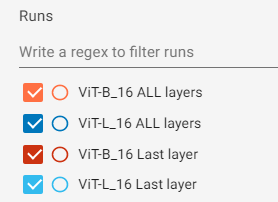
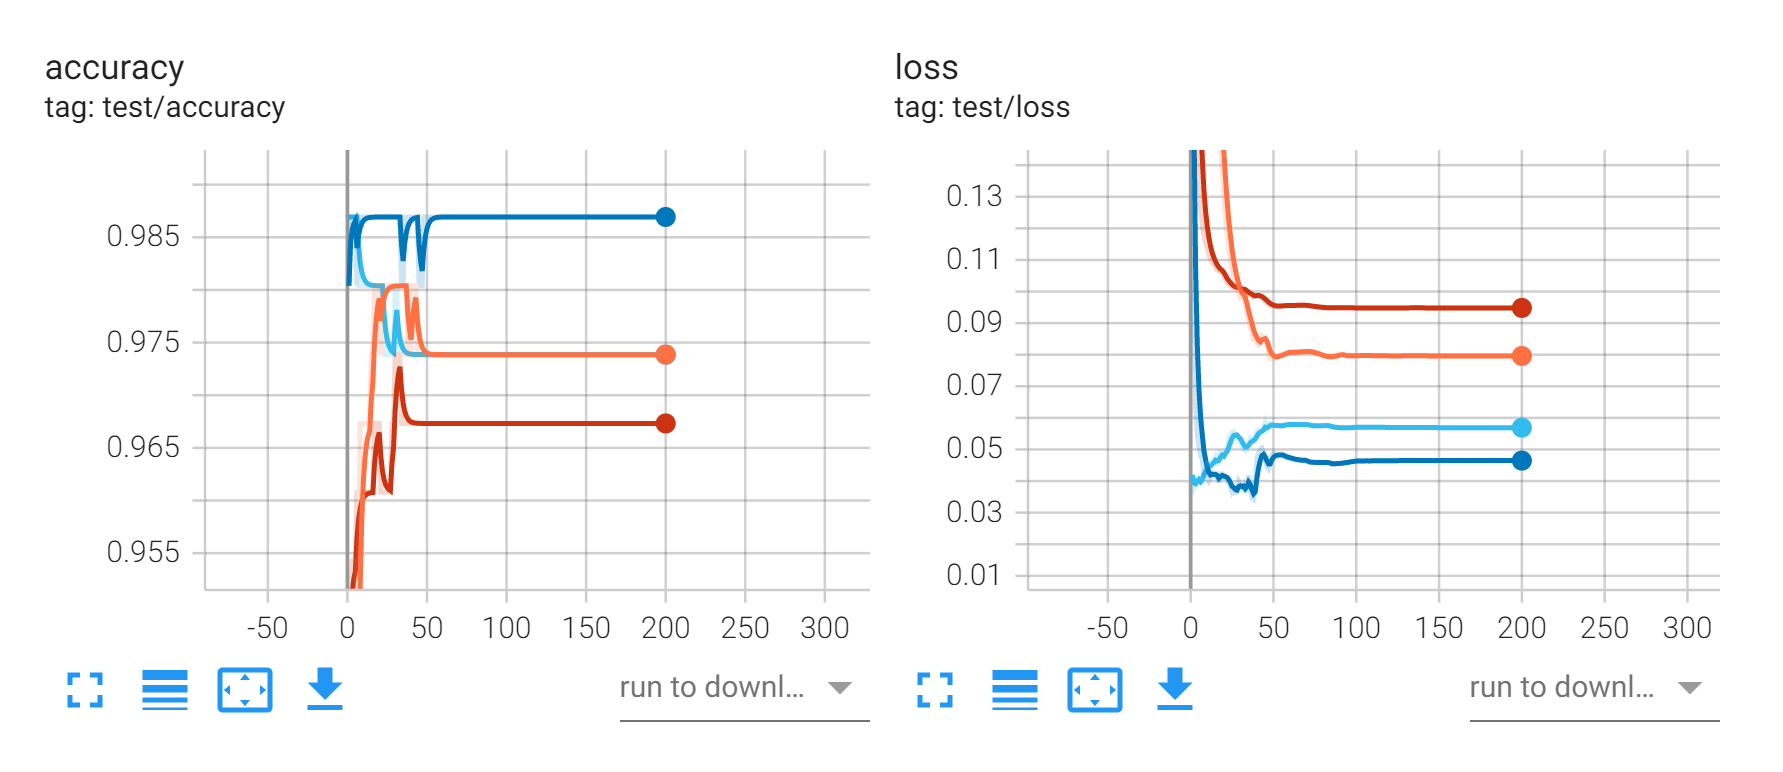
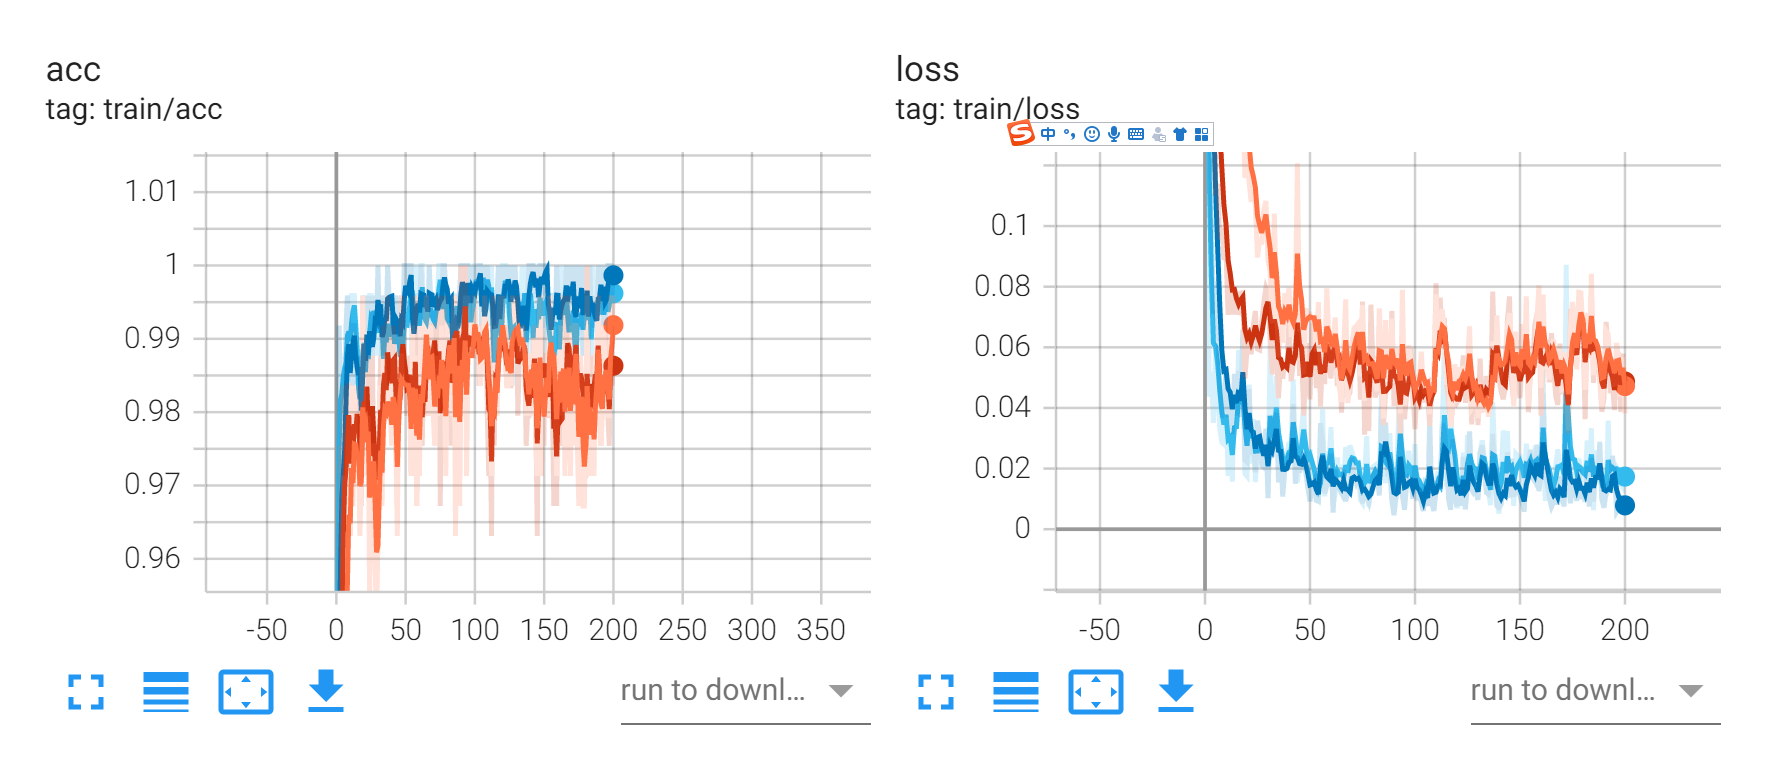

In [1]:
from valid_utils import get_model, valid, imshow, get_valid_res

### ViT-B_16 Last layer

In [3]:
pretrained_dir = "./output/cifar2_only_last_layer_1214_1_checkpoint.bin"
error_cases, error_cases_labels = get_valid_res(pretrained_dir, model_type="ViT-B_16")

***** Current use the cifar2 dataset for train and test.  *****
***** Current use the cifar2 dataset for train and test.  *****
Test Loss: 0.0918 Acc: 0.9739


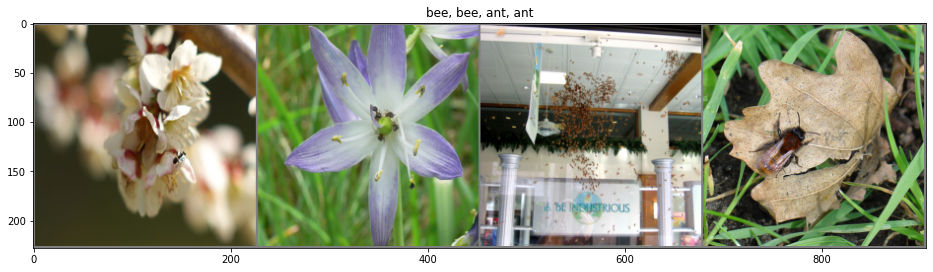

In [4]:
imshow(error_cases, error_cases_labels)

### ViT-B_16 ALL layers

In [5]:
pretrained_dir = "./output/cifar2_all_layers_1213_2_checkpoint.bin"
error_cases, error_cases_labels = get_valid_res(pretrained_dir, model_type="ViT-B_16")

***** Current use the cifar2 dataset for train and test.  *****
***** Current use the cifar2 dataset for train and test.  *****
Test Loss: 0.1519 Acc: 0.9804


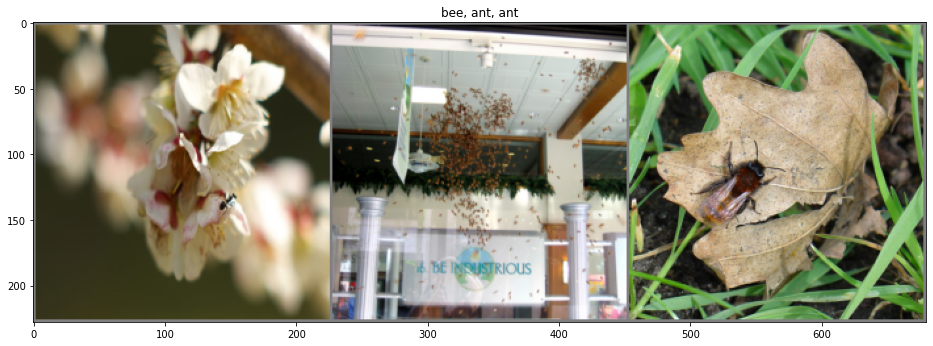

In [6]:
imshow(error_cases, error_cases_labels)

### ViT-L_16 Last layer

In [7]:
pretrained_dir = "./output/cifar2_VIT_L16_only_last_layers_1214_01_checkpoint.bin"
error_cases, error_cases_labels = get_valid_res(pretrained_dir, model_type="ViT-L_16")

***** Current use the cifar2 dataset for train and test.  *****
***** Current use the cifar2 dataset for train and test.  *****
Test Loss: 0.0479 Acc: 0.9869


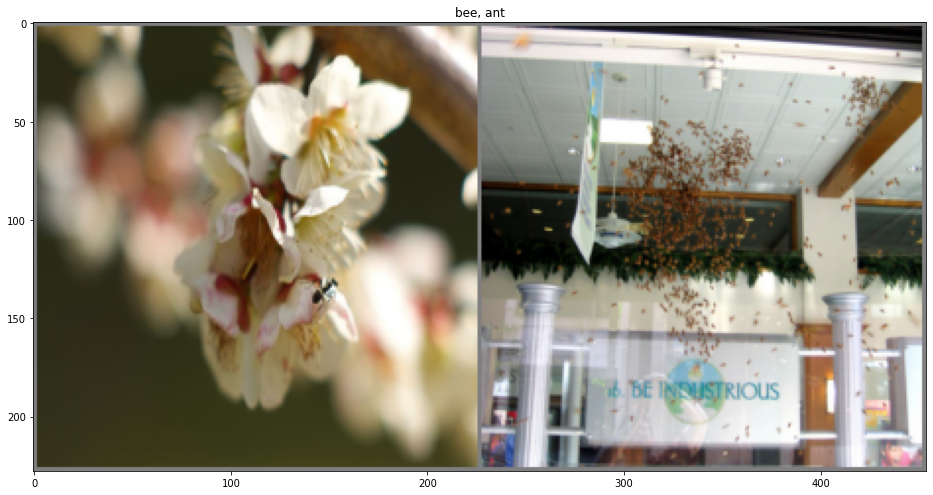

In [8]:
imshow(error_cases, error_cases_labels)

### ViT-L_16 ALL layers

In [9]:
pretrained_dir = "./output/cifar2_VIT_L16_all_layers_1213_01_checkpoint.bin"
error_cases, error_cases_labels = get_valid_res(pretrained_dir, model_type="ViT-L_16")

***** Current use the cifar2 dataset for train and test.  *****
***** Current use the cifar2 dataset for train and test.  *****
Test Loss: 0.0992 Acc: 0.9869


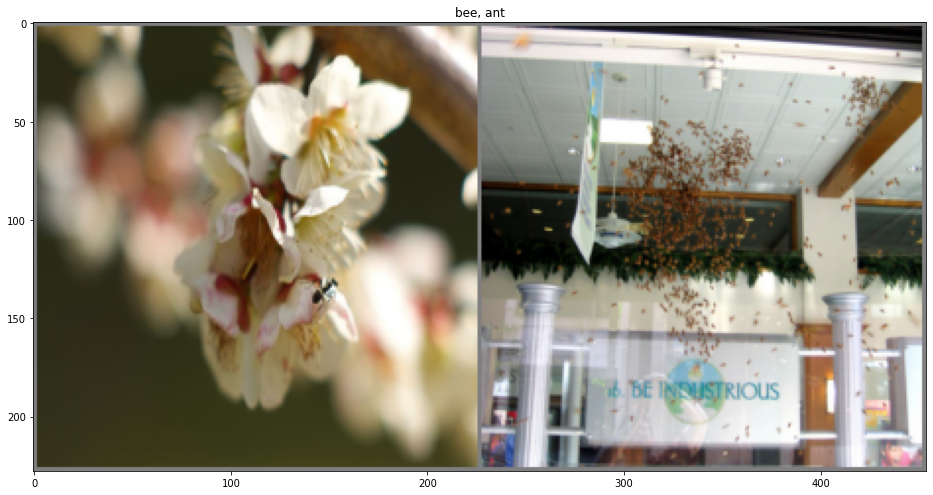

In [10]:
imshow(error_cases, error_cases_labels)

### Visualize the attention map of the wrong predictions

[visualize attention map](./visualize_attention_map.ipynb)

## Conclusion 
- Contextual information
- Data augmentation
- Other pre-trained models